## confirm the profile convolution of clustering is not neccessary
We can skip this convolution to speed up MCMC

Text(0, 0.5, '$w(\\theta)/\\Sigma^c(\\theta)$')

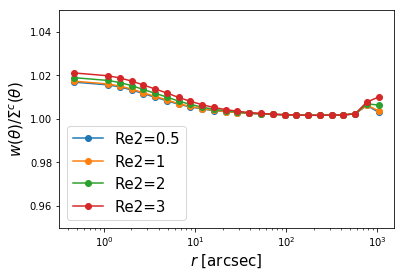

In [16]:
from run_fit import *
param_fit = fit_stacking_mcmc(1, 4, 0)
for Re2 in [0.5, 1, 2, 3]:
    _ = param_fit.get_profgal_model(Re2=Re2)
    profclus_arr = param_fit.get_profclus_model_exact()
    plt.semilogx(param_fit.rfull_arr, param_fit.w_arr/profclus_arr,'o-',label='Re2={}'.format(Re2))
plt.ylim([0.95,1.05])
plt.legend(fontsize=15)
plt.xlabel(r'$r$ [arcsec]',fontsize=15)
plt.ylabel(r'$w(\theta)/\Sigma^c(\theta)$',fontsize=15)

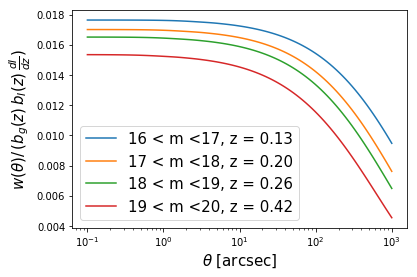

In [3]:
from ciber_info import *
from clustering import *
theta_arr = np.logspace(-1,3,100)
for im,z in enumerate(magbindict['zmean']):
    w_arr = wgI_zm_approx(z, theta_arr)
    plt.semilogx(theta_arr, w_arr, label='%d < m <%d, z = %.2f'%(im+16, im+17, z))
plt.legend(fontsize=15)
plt.xlabel(r'$\theta$ [arcsec]', fontsize=15)
plt.ylabel(r'$w(\theta)/\,(b_g(z)\,b_I(z)\,\frac{dI}{dz})$', fontsize=15)

# plt.savefig('/Users/ytcheng/Desktop/wfunc.png', dpi = 150, bbox_inches='tight')

Text(0.5, 0.98, 'stacked gals SDSS photo-z')

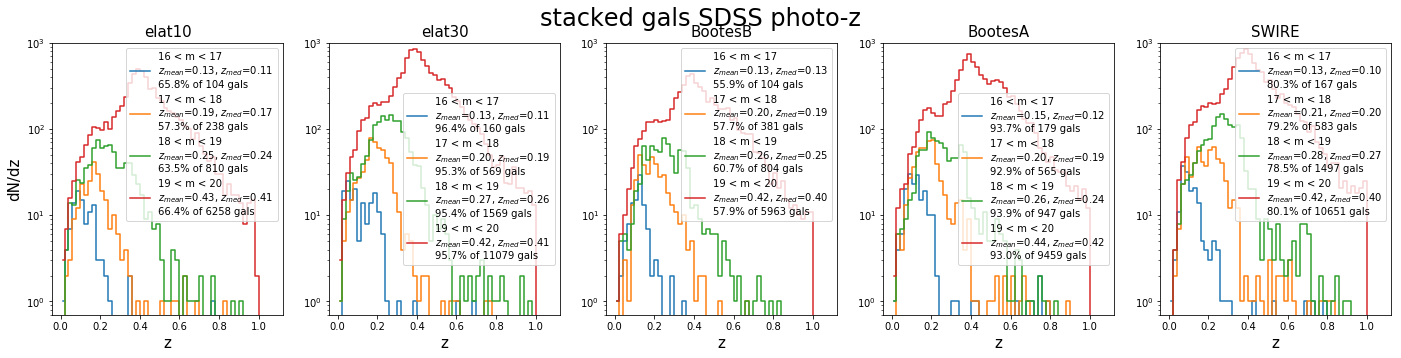

In [26]:
from astropy import units as u

catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'

fig, ax = plt.subplots(1, 5, figsize = (24,5))
for i,ifield in enumerate([4,5,6,7,8]):
    field = fieldnamedict[ifield]
    fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
    df = pd.read_csv(fname)

    binedges = np.arange(0,1.1,0.02)
    bins = (binedges[1:] + binedges[:-1]) / 2

    inst=1
    for im in range(4):
        m_min = im + 16
        m_max = im + 17
        dfi = df.loc[(df['sdssClass']==3) \
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['y'+str(inst)]>-0.5) & (df['y'+str(inst)]<1023.5)\
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['I_comb']>=m_min) & (df['I_comb']<m_max)]
        Nall = len(dfi)
        dfi = dfi.loc[dfi['Photz']>0]
        f = len(dfi)/Nall

        z = np.array(dfi['Photz'])
        ra = np.array(dfi['ra'])
        dec = np.array(dfi['dec'])

        meanz = np.mean(z)
        medianz = np.median(z)
        h,_ = np.histogram(z, bins=binedges)
        ax[i].step(bins,h, where='mid', 
                 label='%d < m < %d\n'%(m_min,m_max) + \
                   r'$z_{mean}$=%.2f, $z_{med}$=%.2f'%(meanz, medianz) + \
                   '\n%.1f%% of %d gals'%(f*100,len(z)))
    ax[i].set_ylim([7e-1, 1e3])
    ax[i].set_xlabel('z', fontsize=15)
    ax[i].set_title('%s'%field, fontsize=15)
    ax[i]
    ax[i].legend()
    ax[i].set_yscale('log')
ax[0].set_ylabel('dN/dz', fontsize=15)
fig.suptitle('stacked gals SDSS photo-z', fontsize=24)

## Linear or Nonlinear Power Spectrum???

In [59]:
import nbodykit.lab
from astropy import units as u
from astropy import cosmology
from astropy import constants as const
cosmo = cosmology.Planck15

z = 0.2
chi = (cosmo.comoving_distance(z)*cosmo.h).value
cosmonbodykit = nbodykit.lab.cosmology.Planck15
cosmonbodykit = cosmonbodykit.clone(P_k_max = 10**3)

Plin = nbodykit.lab.cosmology.LinearPower(cosmonbodykit,
                                          redshift=z, transfer='CLASS')
Pm = nbodykit.lab.cosmology.HalofitPower(cosmonbodykit,
                                          redshift=z)
kbinedges = np.logspace(-3, 3, 1000) #[h/Mpc]
kbins = np.sqrt(kbinedges[:-1] * kbinedges[1:])
dk = kbinedges[1:] - kbinedges[:-1]
Plin = Plin(kbins) #[h^-3/Mpc^3]
Pm = Pm(kbins) #[h^-3/Mpc^3]


theta_arr0 = np.logspace(-1,3.2,100)
theta_arr = (np.array(theta_arr0) * u.arcsec).to(u.rad).value

w_arr = np.zeros_like(theta_arr)
wlin_arr = np.zeros_like(theta_arr)
for i,th in enumerate(theta_arr):
    cum=np.cumsum(dk/2/np.pi*kbins*Pm*scipy.special.jv(0, chi*kbins*th))
    w_arr[i] = cum[-1]
    cumlin=np.cumsum(dk/2/np.pi*kbins*Plin*scipy.special.jv(0, chi*kbins*th))
    wlin_arr[i] = cumlin[-1]

w_arr *= (100/3e5)
wlin_arr *= (100/3e5)

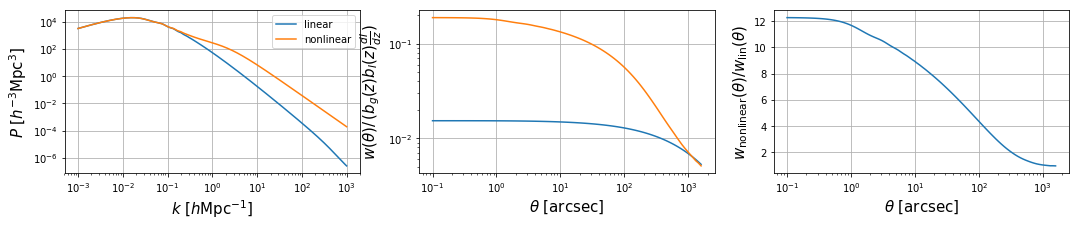

In [56]:
fig, ax = plt.subplots(1, 3, figsize = (18,3))

ax[0].loglog(kbins, Plin, label='linear')
ax[0].loglog(kbins, Pm, label='nonlinear')
ax[0].set_xlabel(r"$k$ $[h \mathrm{Mpc}^{-1}]$", fontsize=15)
ax[0].set_ylabel(r"$P$ $[h^{-3} \mathrm{Mpc}^{3}]$", fontsize=15)
ax[0].legend()
ax[0].grid()

ax[1].loglog(theta_arr0, wlin_arr)
ax[1].loglog(theta_arr0, w_arr)
ax[1].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax[1].set_ylabel(r'$w(\theta)/\,(b_g(z)b_I(z)\frac{dI}{dz})$', fontsize=15)
ax[1].grid()

ax[2].semilogx(theta_arr0, w_arr/wlin_arr)
ax[2].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax[2].set_ylabel(r'$w_{\rm nonlinear}(\theta)/w_{\rm lin}(\theta)$', fontsize=15)
ax[2].grid()

plt.savefig('/Users/ytcheng/Desktop/nonlinear.png', dpi = 150, bbox_inches='tight')

try convolution by integrate $r$ & $\theta$, but it's not really faster than fftconvolve

In [202]:
r_arr = param_fit.rfull_arr
psf_arr = param_fit.profpsf_arr
prof_arr = gal_profile_model().Wang19_profile(param_fit.rfull_arr, param_fit.im, Re2=2)['I_arr']

tcklogpsf = interpolate.splrep(np.log(r_arr),np.log(psf_arr), k=1)
tckloggal = interpolate.splrep(np.log(r_arr),np.log(prof_arr), k=1)

profgalconv_arr = np.zeros_like(galprof)
thint_arr = np.arange(0,2*np.pi,0.01)
rint_arr = np.arange(0.01,1200,0.1)
for ir,r in enumerate(r_arr):
    
    fint_arr = np.zeros_like(rint_arr)
    for ir1,r1 in enumerate(rint_arr):
        arg = np.sqrt((r+r1*np.cos(thint_arr))**2 + (r1*np.sin(thint_arr))**2)
        fint = np.exp(interpolate.splev(np.log(arg),tckloggal))
        fint_arr[ir1] = np.sum(fint) * (thint_arr[1] - thint_arr[0])
    
    gint_arr = np.exp(interpolate.splev(np.log(rint_arr),tcklogpsf))
    
    num = np.sum(fint_arr * gint_arr * rint_arr) * (rint_arr[1] - rint_arr[0])
    den = np.sum(gint_arr * rint_arr) * (rint_arr[1] - rint_arr[0]) * 2 * np.pi
    profgalconv_arr[ir] = num / den